## Results of AutoAugment Training a Resnet-18 with a PPO Agent
### Objective
Three models were trained in parallel (RL-augmented, randomly augmented, no augmentation) to classify images from the CIFAR-10 dataset, choosing one out of ten classes. The goal was to (1) reproduce results using an similar approach and (2) add a baseline comparison - a model trained with random augmentation - to assess whether RL-augmented training truly strengthens generalization. For the sake of completeness, the model trained without any augmentation should serve as another baseline to evaluate the overall performance gain of augmentation.
### Description of DAC using RL
Dynamic algorithm configuration in essence means optimizing any algorithm (mostly DL) dynamically. Usually, that means optimize specific parameters on-the-fly during training. In this case, tuning the strategy of augmenting images that are fed into a CNN. This could involve cropping, flipping, mirroring or changing contrast. The RL agent should learn a policy during training, which augmentation strategies (the actions) out of a search space (which is the same as the baseline) are optimally so that the learner (the CNN) generalizes well on the validation set. This can be seen as a grey-box optimization problem, because the agent can see the training dynamics (instead of only seeing the result AFTER the learner was trained). Whether or not the computational expense are worth the result can only show in validating with the held-out set.

## Get files

In [2]:
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from main import METRICS_PATH, SEEDS

trainingmetrics_list = []
testmetrics_list = []
agentmetrics = []

loss_list_rl_model = []
loss_list_rand_model = []
loss_list_base_model = []

acc_list_rl_model = []
acc_list_rand_model = []
acc_list_base_model = []

for i, seed in enumerate(SEEDS):
    METRICS_FILENAME = f"data/metrics/final_metrics_seednr_{seed}.csv"
    TESTMETRICS_FILENAME = f"data/metrics/final_testmetrics_seednr_{seed}.csv"
    AGENTPOLICIES_FILENAME = f"data/metrics/agent_policies_seednr_{seed}.csv"
    
    try:
        # Get files
        trainingmetrics_df = pd.read_csv(METRICS_FILENAME)
        testmetrics_list.append(pd.read_csv(TESTMETRICS_FILENAME))
        agentmetrics.append(pd.read_csv(AGENTPOLICIES_FILENAME))
    except Exception as e:
        print(f"Files do not exist: {e}")

    # Convert to np arrays
    loss_rl = np.array(literal_eval(trainingmetrics_df['rl'][0]))
    loss_rand = np.array(literal_eval(trainingmetrics_df['random'][0]))
    loss_base = np.array(literal_eval(trainingmetrics_df['none'][0]))

    loss_list_rl_model.append(loss_rl)
    loss_list_rand_model.append(loss_rand)
    loss_list_base_model.append(loss_base)
    
    acc_rl = np.array(literal_eval(trainingmetrics_df['rl'][1]))
    acc_rand = np.array(literal_eval(trainingmetrics_df['random'][1]))
    acc_base = np.array(literal_eval(trainingmetrics_df['none'][1]))
    
    acc_list_rl_model.append(acc_rl)
    acc_list_rand_model.append(acc_rand)
    acc_list_base_model.append(acc_base)

## Plots

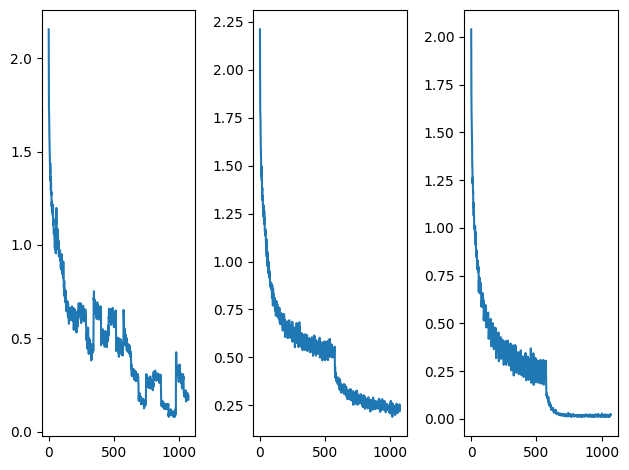

In [7]:
import matplotlib.pyplot as plt

n = 56
avgResult_rl = np.average(loss_list_rl_model[0].reshape(-1, n), axis=1)
avgResult_rand = np.average(loss_list_rand_model[0].reshape(-1, n), axis=1)
avgResult_base = np.average(loss_list_base_model[0].reshape(-1, n), axis=1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(avgResult_rl)
ax2.plot(avgResult_rand)
ax3.plot(avgResult_base)
plt.tight_layout()
plt.show()

In [4]:
trainingmetrics_list[0]['rl'][1]

IndexError: list index out of range